
•	Вариант 1
1.	Написать на языке Python класс выполняющий функциональность модулятора QAM (QPSK, QAM16, QAM64)
2.	Написать на языке Python класс выполняющий функциональность добавления гауссовского шума к созвездию QAM
3.	Написать на языке Python класс выполняющий функциональность демодулятора QAM (QPSK, QAM16, QAM64)
4.	Написать последовательный вызов 1-3 для случайной последовательности бит для разных значений дисперсия шума
5.	Построить график зависимости вероятности ошибки на бит от  дисперсии шума


<ipython-input-16-10602f49ed9b>:280: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


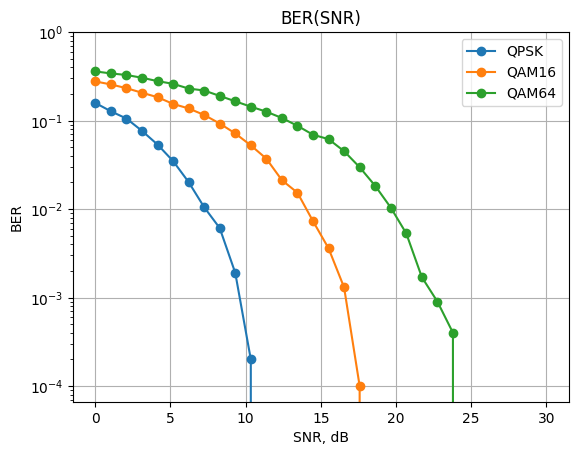

In [16]:
import numpy as np
import matplotlib.pyplot as plt


#1. Class QAM modulation
class QAMModulator:
    def __init__(self, points, fc):
        '''
        Parameters:
        points: list QAM complex symbols
        fc: carrier frequency
        '''
        self.points = points
        self.fc = fc

    def modulate(self, input_bits):
        '''
        Parameters
        bits: list bit sequence to be modulated

        Returns:
        modulated_symbols: list of modulated_symbols
        '''
        modulated_symbols = []

        # Iterate over a sequence of bits in increments corresponding to the number of bits per symbol
        for i in range(0, len(input_bits), int(np.log2(len(self.points)))):

            # Getting a group of bits for the current symbol (4,8,16)
            bits = input_bits[i:i + int(np.log2(len(self.points)))]

            # Convert bits to index of symbol
            symbol_idx = int("".join(map(str, bits)), 2)

            # Calculating the phase shift for the current symbol
            phase_shift = 2 * np.pi * self.fc * i

            # QAM symbol modulation with phase shift
            modulated_symbol = self.points[symbol_idx] * np.exp(1j * phase_shift)
            modulated_symbols.append(modulated_symbol)

        return modulated_symbols


#2. Class adding AWGN
class GaussianNoise:
    def __init__(self,SNRdB):
        '''
        Parameters:
        SNRdB = Signal-to-Noise Ratio in decibels
        '''
        self.SNRdB = SNRdB
        pass


    def add_noise(self,symbols, L=1):
        """
        Parameters:
            symbols: list of modulated symbols
            SNRdB: signal-to-noise ratio (in decibels)
            L: oversampling factor (applicable for waveform simulation), default L = 1.

        Return:
            noisy_symbols: modulated sequence with AWGN
        """
        symbols = np.array(symbols)
        # SNR to linear scale
        gamma = 10 ** (self.SNRdB / 10)
        # Actual power
        P = L * np.sum(np.abs(symbols) ** 2) / len(symbols)
        # Noise spectral density
        N0 = P / gamma
        # Compute noise
        n = np.sqrt(N0 / 2) * (np.random.standard_normal(symbols.shape) + 1j * np.random.standard_normal(symbols.shape))
        # Signal + noise
        noisy_symbols = symbols + n
        return noisy_symbols


#3. Class QAM demodulation
class QAMDemodulator:
    def __init__(self, points, fc):
        '''
        Parameters
        points: list of QAM complex symbols
        fc: carrier frequency
        '''
        self.points = points
        self.fc = fc

    def demodulate(self, received_symbols):
        '''
        Parameters
        received_symbols: received symbols

        Returns:
        noisy_symbols: demodulated symbols
        '''
        demodulated_bits = []
        # Iterate over received symbols
        for symbol in received_symbols:

            # Phase shift calculation
            phase_shift = -2 * np.pi * self.fc * len(demodulated_bits)

            # Phase shif  compensation
            symbol *= np.exp(1j * phase_shift)

            # Calculating the distance between the received symbol and each constellation point
            distances = [np.abs(symbol - point) for point in self.points]

            # Determining the index of the constellation point closest to the received symbol
            symbol_idx = distances.index(min(distances))

            # Convert index to bit sequence and add to demodulated bits
            demodulated_bits.extend(self._int_to_bits(symbol_idx,int(np.log2(len(self.points)))))

        return demodulated_bits


    # Method for converting an integer to a sequence of bits (the binary representation of a number)
    def _int_to_bits(self, value, num_bits):

        return [int(bit) for bit in format(value, f'0{num_bits}b')]


## Simulation
num_bits = 10000

# list of SNR
snr_values = np.linspace(0, 30, 30)

# QPSK, QAM16, QAM64
qam_order_list = [4, 16, 64]

# Error number storage list for each QAM order
bit_errors = [[] for _ in qam_order_list]

# Frequency carrier
fc = 100000

for qam_order_index, qam_order in enumerate(qam_order_list):

    # Creating constellation symbols for a certain QAM modulation (data taken from 3GPP TS 36.211)
    if qam_order == 4:
        # Define QPSK points
        points = [1/np.sqrt(2) + 1j/np.sqrt(2),
                  1/np.sqrt(2) - 1j/np.sqrt(2),
                  -1/np.sqrt(2) + 1j/np.sqrt(2),
                  -1/np.sqrt(2) - 1j/np.sqrt(2)]
    elif qam_order == 16:
        # Define QAM16 points
        points =     [
    1/np.sqrt(10) + 1j/np.sqrt(10),
    1/np.sqrt(10) + 3j/np.sqrt(10),
    3/np.sqrt(10) + 1j/np.sqrt(10),
    3/np.sqrt(10) + 3j/np.sqrt(10),
    1/np.sqrt(10) - 1j/np.sqrt(10),
    1/np.sqrt(10) - 3j/np.sqrt(10),
    3/np.sqrt(10) - 1j/np.sqrt(10),
    3/np.sqrt(10) - 3j/np.sqrt(10),
    -1/np.sqrt(10) + 1j/np.sqrt(10),
    -1/np.sqrt(10) + 3j/np.sqrt(10),
    -3/np.sqrt(10) + 1j/np.sqrt(10),
    -3/np.sqrt(10) + 3j/np.sqrt(10),
    -1/np.sqrt(10) - 1j/np.sqrt(10),
    -1/np.sqrt(10) - 3j/np.sqrt(10),
    -3/np.sqrt(10) - 1j/np.sqrt(10),
    -3/np.sqrt(10) - 3j/np.sqrt(10)
]
    elif qam_order == 64:
        # Define QAM64 points
        points = [
    3/np.sqrt(42) + 3j/np.sqrt(42),
    3/np.sqrt(42) + 1j/np.sqrt(42),
    1/np.sqrt(42) + 3j/np.sqrt(42),
    1/np.sqrt(42) + 1j/np.sqrt(42),
    3/np.sqrt(42) + 5j/np.sqrt(42),
    3/np.sqrt(42) + 7j/np.sqrt(42),
    1/np.sqrt(42) + 5j/np.sqrt(42),
    1/np.sqrt(42) + 7j/np.sqrt(42),
    5/np.sqrt(42) + 3j/np.sqrt(42),
    5/np.sqrt(42) + 1j/np.sqrt(42),
    7/np.sqrt(42) + 3j/np.sqrt(42),
    7/np.sqrt(42) + 1j/np.sqrt(42),
    5/np.sqrt(42) + 5j/np.sqrt(42),
    5/np.sqrt(42) + 7j/np.sqrt(42),
    7/np.sqrt(42) + 5j/np.sqrt(42),
    7/np.sqrt(42) + 7j/np.sqrt(42),
    -3/np.sqrt(42) + 3j/np.sqrt(42),
    -3/np.sqrt(42) + 1j/np.sqrt(42),
    -1/np.sqrt(42) + 3j/np.sqrt(42),
    -1/np.sqrt(42) + 1j/np.sqrt(42),
    -3/np.sqrt(42) + 5j/np.sqrt(42),
    -3/np.sqrt(42) + 7j/np.sqrt(42),
    -1/np.sqrt(42) + 5j/np.sqrt(42),
    -1/np.sqrt(42) + 7j/np.sqrt(42),
    -5/np.sqrt(42) + 3j/np.sqrt(42),
    -5/np.sqrt(42) + 1j/np.sqrt(42),
    -7/np.sqrt(42) + 3j/np.sqrt(42),
    -7/np.sqrt(42) + 1j/np.sqrt(42),
    -5/np.sqrt(42) + 5j/np.sqrt(42),
    -5/np.sqrt(42) + 7j/np.sqrt(42),
    -7/np.sqrt(42) + 5j/np.sqrt(42),
    -7/np.sqrt(42) + 7j/np.sqrt(42),
    3/np.sqrt(42) - 3j/np.sqrt(42),
    3/np.sqrt(42) - 1j/np.sqrt(42),
    1/np.sqrt(42) - 3j/np.sqrt(42),
    1/np.sqrt(42) - 1j/np.sqrt(42),
    3/np.sqrt(42) - 5j/np.sqrt(42),
    3/np.sqrt(42) - 7j/np.sqrt(42),
    1/np.sqrt(42) - 5j/np.sqrt(42),
    1/np.sqrt(42) - 7j/np.sqrt(42),
    5/np.sqrt(42) - 3j/np.sqrt(42),
    5/np.sqrt(42) - 1j/np.sqrt(42),
    7/np.sqrt(42) - 3j/np.sqrt(42),
    7/np.sqrt(42) - 1j/np.sqrt(42),
    5/np.sqrt(42) - 5j/np.sqrt(42),
    5/np.sqrt(42) - 7j/np.sqrt(42),
    7/np.sqrt(42) - 5j/np.sqrt(42),
    7/np.sqrt(42) - 7j/np.sqrt(42),
    -3/np.sqrt(42) - 3j/np.sqrt(42),
    -3/np.sqrt(42) - 1j/np.sqrt(42),
    -1/np.sqrt(42) - 3j/np.sqrt(42),
    -1/np.sqrt(42) - 1j/np.sqrt(42),
    -3/np.sqrt(42) - 5j/np.sqrt(42),
    -3/np.sqrt(42) - 7j/np.sqrt(42),
    -1/np.sqrt(42) - 5j/np.sqrt(42),
    -1/np.sqrt(42) - 7j/np.sqrt(42),
    -5/np.sqrt(42) - 3j/np.sqrt(42),
    -5/np.sqrt(42) - 1j/np.sqrt(42),
    -7/np.sqrt(42) - 3j/np.sqrt(42),
    -7/np.sqrt(42) - 1j/np.sqrt(42),
    -5/np.sqrt(42) - 5j/np.sqrt(42),
    -5/np.sqrt(42) - 7j/np.sqrt(42),
    -7/np.sqrt(42) - 5j/np.sqrt(42),
    -7/np.sqrt(42) - 7j/np.sqrt(42)]

    # Create a list to store the number of errors for the current QAM order
    bit_errors[qam_order_index] = []

    for snr_db in snr_values:
        # Create a QAM modulator object
        qam_modulator = QAMModulator(points, fc)

        # Create a QAM demodulator object
        qam_demodulator = QAMDemodulator(points, fc)

        # Create an object to add Gaussian noise
        gaussian_noise = GaussianNoise(snr_db)

        # Calculate the number of QAM
        num_symbols = num_bits // int(np.log2(qam_order))

        # Generate random bit sequence for modulation
        input_bits = np.random.randint(2, size=num_symbols * int(np.log2(qam_order)))
        modulated_symbols = qam_modulator.modulate(input_bits)

        # Adding noise to modulated symbols
        noisy_symbols = gaussian_noise.add_noise(modulated_symbols)

        # Noisy symbol demodulation
        demodulated_bits = qam_demodulator.demodulate(noisy_symbols)

        # Calculating the number of errors per bit and adding to the list
        bit_errors[qam_order_index].append(np.sum(np.abs(np.array(input_bits) - np.array(demodulated_bits))))


#4. Plot BER(SNR)
qam_order_names = ['QPSK', 'QAM16', 'QAM64']
for qam_order_index, qam_order in enumerate(qam_order_list):
    qam_name = qam_order_names[qam_order_index]
    ber_per_qam = np.array(bit_errors[qam_order_index]) / num_bits
    plt.plot(snr_values, ber_per_qam, marker='o', label=f'{qam_name}')

plt.yscale('log')
plt.xlabel('SNR, dB')
plt.ylabel('BER')
plt.title('BER(SNR)')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()